In [1]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [2]:
# -------------------------------------- External Libraries --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------- Local Imports ----------------------------------------
from src.core                  import LoRaPhyParams, LoRaFrameParams
from src.codec                 import LoRaCodec
from src.mod                   import LoRaModulator, plot_frame
from src.demod                 import LoRaDemodulator, plot_demodulation
from src.sync                  import DechirpBasedSynchronizer
from src.sync                  import plot_synchronization

import src.core.sdr_utils      as sdr_utils
import src.core.snr_utils      as snr_utils
import src.core.vpn_utils      as vpn_utils
import src.core.misc_utils     as misc_utils
import src.core.perf_metrics_utils as perf_utils

In [3]:
def get_perf_metrics(channel_fn_id, sf, mode):
    filename = f"{channel_fn_id}/perf_sf{sf}_500k_2spc_{mode}.json"
    return perf_utils.SNRPerformanceMetrics.load(filename)

def plot_and_show_metric(perf_metric):
    fig, axs = plt.subplots(1, 1, figsize=(15, 8))
    logscale = not "async" in perf_metric.channel_function
    perf_utils.plot_snr_performance(perf_metric, ax=axs, logscale=logscale)
    perf_utils.annotate_perf_metadata(perf_metric, ax=axs)
    if "async" in perf_metric.channel_function:
        fold_mode_to_show = perf_metric.profile.fold_mode.upper() if perf_metric.profile.fold_mode != "0FPA" else "FPA"
        perf_utils.plot_theoric_perf(axs, fold_mode_to_show=fold_mode_to_show)
    fig.tight_layout()
    plt.show()

def plot(perf_metric, ax, logscale, fold_mode, use_fn):
    if use_fn == "plot":
        perf_utils.plot_snr_performance(perf_metric, ax=ax, logscale=logscale)
    elif use_fn == "theoric":
        perf_utils.plot_theoric_perf(ax, fold_mode_to_show=fold_mode)
    elif use_fn == "annotate":
        perf_utils.annotate_perf_metadata(perf_metric, ax=ax)



# Métricas de Rendimiento

Como ya se discutió en `00_docs/about_noise_and_performance.ipynb`, la existencia de perfiles LoRa nos permite corroborar cómo rinde cada uno de ellos en condiciones específicas. En particular, esto se logra a través de las utilidades definidas en el módulo `perf_metrics_utils`, y más específicamente con la clase `SNRPerformanceMetrics`.

## 1. ¿Qué es un *SNRPerformanceMetrics*?

Se trata de una clase que encapsula:

- Un perfil LoRa (`SDRProfile`) que describe los parámetros físicos (SF, BW, SPC) y de framing (header explícito, sync word, etc).
- Opcionalmente, parámetros SDR para transmisión y recepción (en el caso de perfiles reales).
- Una lista de puntos de evaluación `SNRPointPerformanceMetrics`, cada uno evaluado a un nivel de SNR dado.
- El nombre de la función de canal (`channel_function`) utilizada para degradar la señal transmitida.

Cada punto `SNRPointPerformanceMetrics` puede contener tres métricas: BER, SER y FER, representadas como instancias de `SinglePerformancePoint`, con sus respectivos errores, cantidad de ensayos, intervalo de confianza, y si el punto es estadísticamente confiable o no para une tolerancia relativa específica, comparando su "ancho de confianza relativo" a través de intervalos de confianza computaods con el método de Wilson.


## 2. Evaluación Cuantitativa Automática

El notebook `quantitative_tests` es el encargado de generar estos objetos de forma estructurada. Para cada valor de SNR objetivo, se simula (o ejecuta en SDRs reales) un número variable de transcepciones. Por cada transcepción, se:

1. Transmite un frame o payload.
2. Aplica una función de canal (simulada o real) para degradar la señal.
3. Sincroniza (si el canal requiere sincronización), demodula y calcula errores comparando con el payload original.
4. Acumula errores de bit, símbolo y frame.
5. Calcula la tasa de error estimada y su intervalo de confianza (usando el método Wilson).
6. Evalúa si ese punto de SNR alcanzó el umbral de confiabilidad definido por un `rel_half_width`.

Esto continúa hasta alcanzar un número de símbolos suficiente, o un máximo predefinido (este número variable de transcepciones).

## 3. Funciones de Canal

Cada canal afecta el frame de forma distinta, y es el punto clave de comparación entre perfiles:

- `sim_async_awgn`: Agrega ruido blanco gaussiano aditivo e ignora la trama, solo se enfoca en la demodulación del payload.

- `sim_async_echo`: Agrega AWGN y además aplica un canal multipath de dos taps, emulando un eco de una muestra de distancia.

- `sim_sync_awgn`: Agrega ruido blanco gaussiano aditivo y además desplaza la trama para simular un escenario en el cual el receptor capturó al buffer de forma no alineada (con `np.roll`).

- `sim_sync_echo`: Agrega AWGN y además aplica el mismo canal multipath, esta vez teniendo en cuenta el concepto de trama.

- `real_single_sdr`: Transmite y recibe mediante el mismo SDR, utilizando como parámetro la atenuación apropiada para generar el SNR objetivo (mediante la función `profile.get_atten_for_snr`).

- `real_dual_sdr`: Transmite y recibe mediante dos SDRs, también utilziando la atenuación apropiada. Tiene más guardas debido a la desincronización más evidente (`time.sleep` entre transmisión y recepción, descarte de algunos buffers)

Esto permite aislar el impacto de errores específicos:
- Comparar FPA de 0°, CPA y FPA en términos de sincronización y performance.
- Estimar cuánto se degrada el canal real vs. el canal ideal.
- Evaluar cómo varía la robustez frente al tipo de canal.

## 4. Visualización y Anotaciones

- Las funciones `plot_snr_performance()` y `annotate_perf_metadata()` permiten graficar los resultados e incrustar los metadatos experimentales directamente en los ejes.
- Adicionalmente, `plot_theoric_perf()` permite superponer curvas teóricas "esperadas" (hardcodeadas, según los resultados del paper) para compararlas visualmente con lo obtenido.
- Todos los gráficos son compatibles con sistemas de subplots (`ax`), permitiendo collages y análisis comparativo.


## 5. Persistencia y Logging

Durante las pruebas, se almacenan logs temporales (`.log`) con los resultados frame a frame y se almacenan resultados finales en JSON a través de `SNRPerformanceMetrics.save()`.

Esto permite:
- Repetibilidad exacta de experimentos.
- Comparación entre configuraciones y canales.
- Control sobre la confiabilidad estadística del resultado (se evita sobreajuste a muestras pequeñas).


## Distintos *modos* de Decimación: 0FPA, FPA y CPA

En el paper se expone que la versión ideal (la que aquí supone una rotación de 0 grados, es decir 0FPA) es incorrecta para entornos reales ya que el oscilador encargado de llevar nuestros chips LoRa a señales físicas es imperfecto a la hora de representar los saltos de frecuencia característicos de cualquier señal-símbolo LoRa.

Por eso, debe existir una correción de frecuencia fuera de CFO y SFO, que se aplique símbolo a símbolo intentando mitigar esto.

Esto se realiza en el paper de dos maneras: 
- Tanto con un sistema granular que prueba rotaciones complejas a la transformada de fourier de la señal "dechirp" llamado FPA.
- Como un sistema más "*tosco*" que simplemente descarta por completo la rotación de los segmentos de la FFT para centrarse en su magnitud.




### Rendimiento FPA Ideal y medido, canal sin trama con AWGN

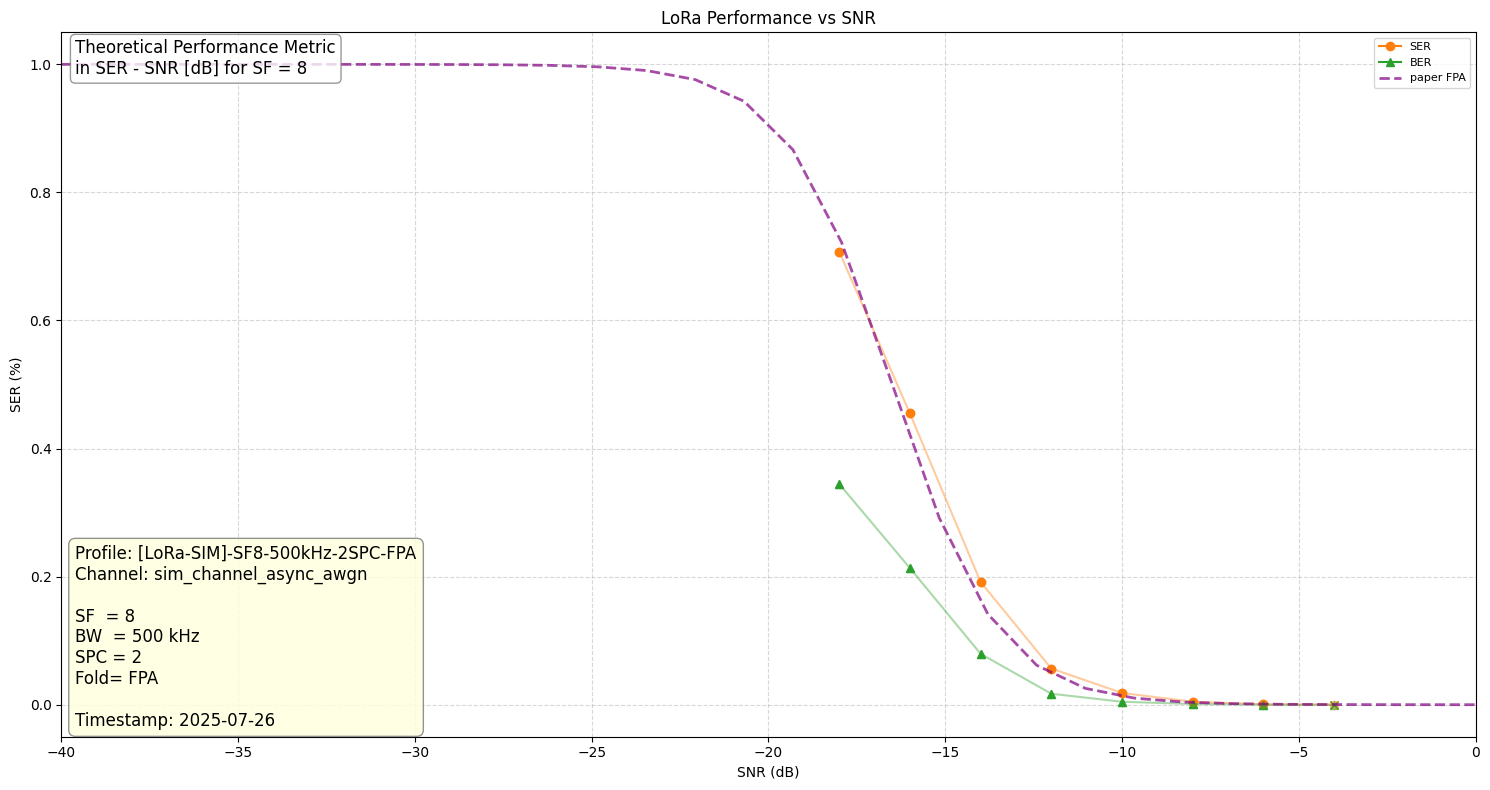

In [4]:
plot_and_show_metric(get_perf_metrics("sim_async_awgn", "8", "fpa"))

### Rendimiento CPA Ideal y medido, canal sin trama con AWGN

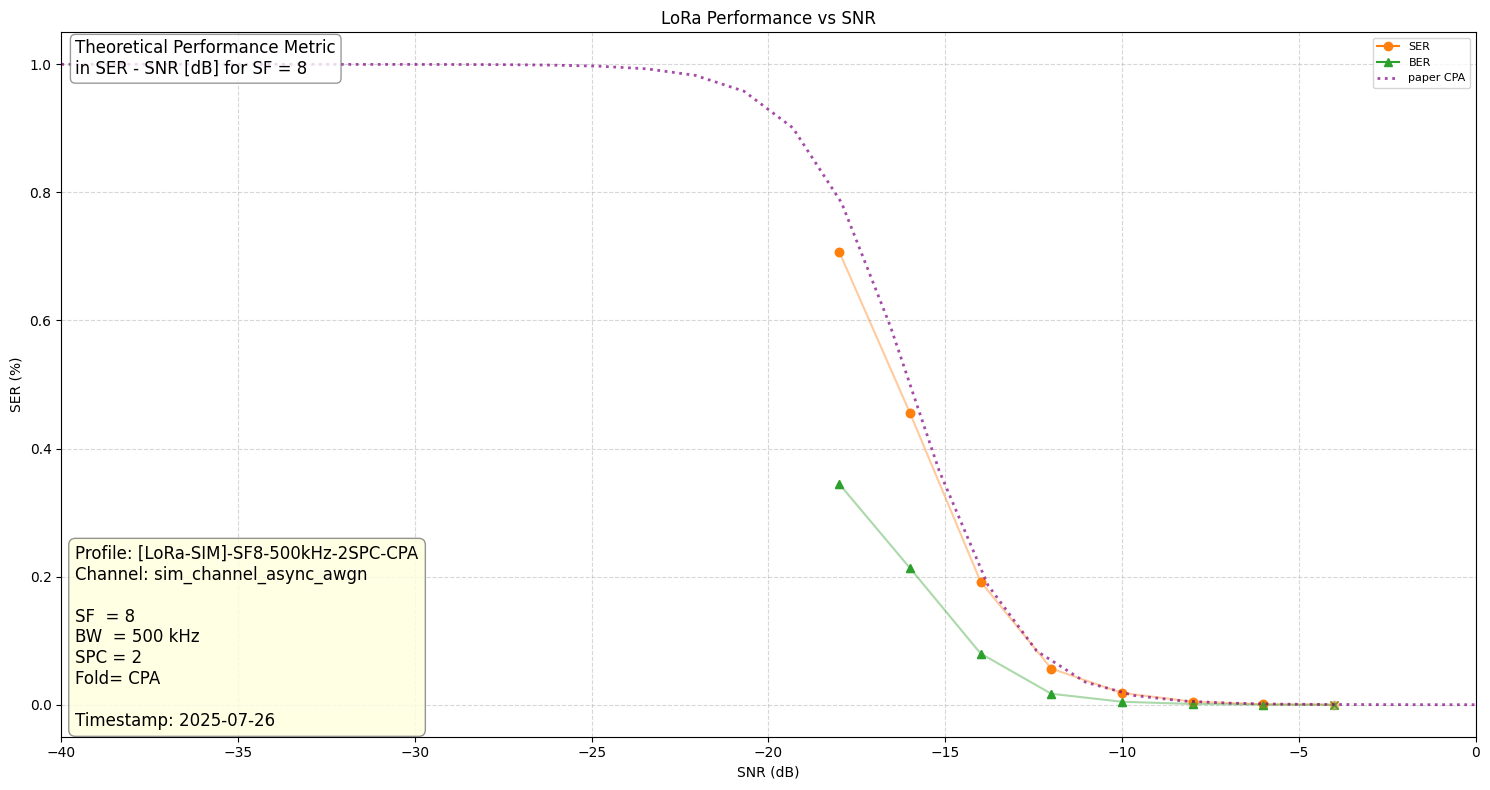

In [5]:
plot_and_show_metric(get_perf_metrics("sim_async_awgn", "8", "cpa"))

### Métricas de Rendimiento con alineación de Trama

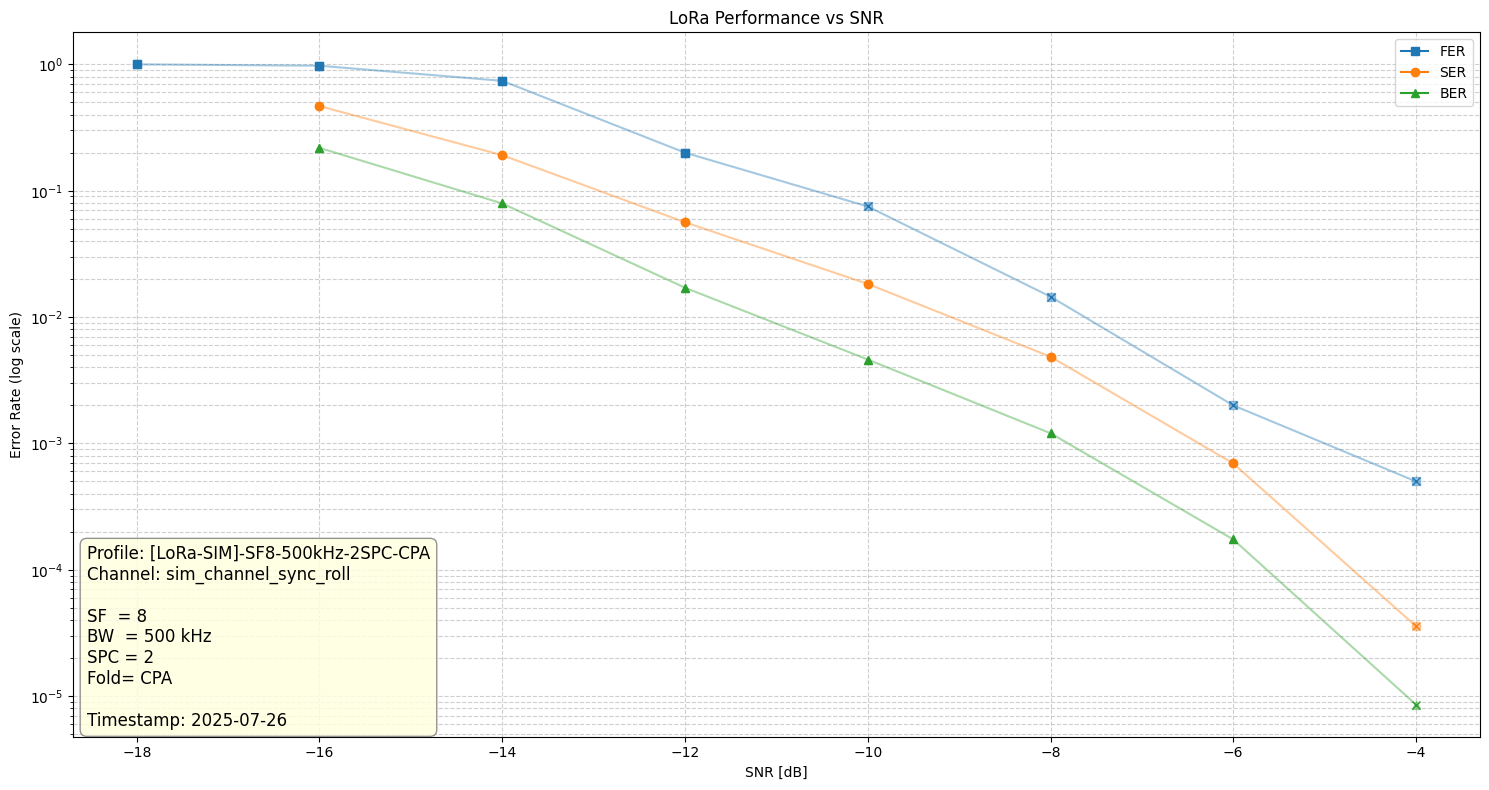

In [6]:
plot_and_show_metric(get_perf_metrics("sim_sync_awgn", "8", "cpa"))

In [7]:
def plot_comparison_cpa_sim_sdr():    
    sim_cpa_perf = get_perf_metrics("sim_sync_awgn", "8", "cpa")
    sim_snr_db = np.array([pt.snr_db for pt in sim_cpa_perf.snr_points])
    ser = np.array([
        pt.ser.p_hat if pt.ser is not None and pt.ser.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])
        
    sim_fer = np.array([
        pt.fer.p_hat if pt.fer is not None and pt.fer.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])
    sim_ber = np.array([
        pt.ber.p_hat if pt.ber is not None and pt.ber.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])

    sdr_cpa_perf = get_perf_metrics("real_single_sdr", "8", "cpa")
    sdr_snr_db = np.array([pt.snr_db for pt in sdr_cpa_perf.snr_points])
    sdr_ser = np.array([pt.ser.p_hat for pt in sdr_cpa_perf.snr_points])
    sdr_fer = np.array([pt.fer.p_hat for pt in sdr_cpa_perf.snr_points])
    sdr_ber = np.array([pt.ber.p_hat for pt in sdr_cpa_perf.snr_points])

    fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    fig.suptitle("Comparación entre la simulación de CPA y la medición real con SDR singular", fontsize=16)

    # 1. Plot Frame Error Rate (FER)
    axs[0].plot(sim_snr_db, sim_fer, label="Simulación CPA", marker='o', linestyle='-')
    axs[0].plot(sdr_snr_db, sdr_fer, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[0].set_xlabel("SNR [dB]")
    axs[0].set_ylabel("FER")
    axs[0].set_title("Frame Error Rate (FER)")
    axs[0].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[0].set_yscale("log")
    axs[0].legend() 

    # 2. Plot Bit Error Rate (BER)
    axs[1].plot(sim_snr_db, sim_ber, label="Simulación CPA", marker='o', linestyle='-')
    axs[1].plot(sdr_snr_db, sdr_ber, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[1].set_xlabel("SNR [dB]")
    axs[1].set_ylabel("BER")
    axs[1].set_title("Bit Error Rate (BER)")
    axs[1].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[1].set_yscale("log")
    axs[1].legend()

    # 3. Plot Symbol Error Rate (SER)
    axs[2].plot(sim_snr_db, ser, label="Simulación CPA", marker='o', linestyle='-')
    axs[2].plot(sdr_snr_db, sdr_ser, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[2].set_xlabel("SNR [dB]")
    axs[2].set_ylabel("SER")
    axs[2].set_title("Symbol Error Rate (SER)")
    axs[2].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[2].set_yscale("log")
    axs[2].legend() 

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

## Métricas de Rendimiento con SDR singular


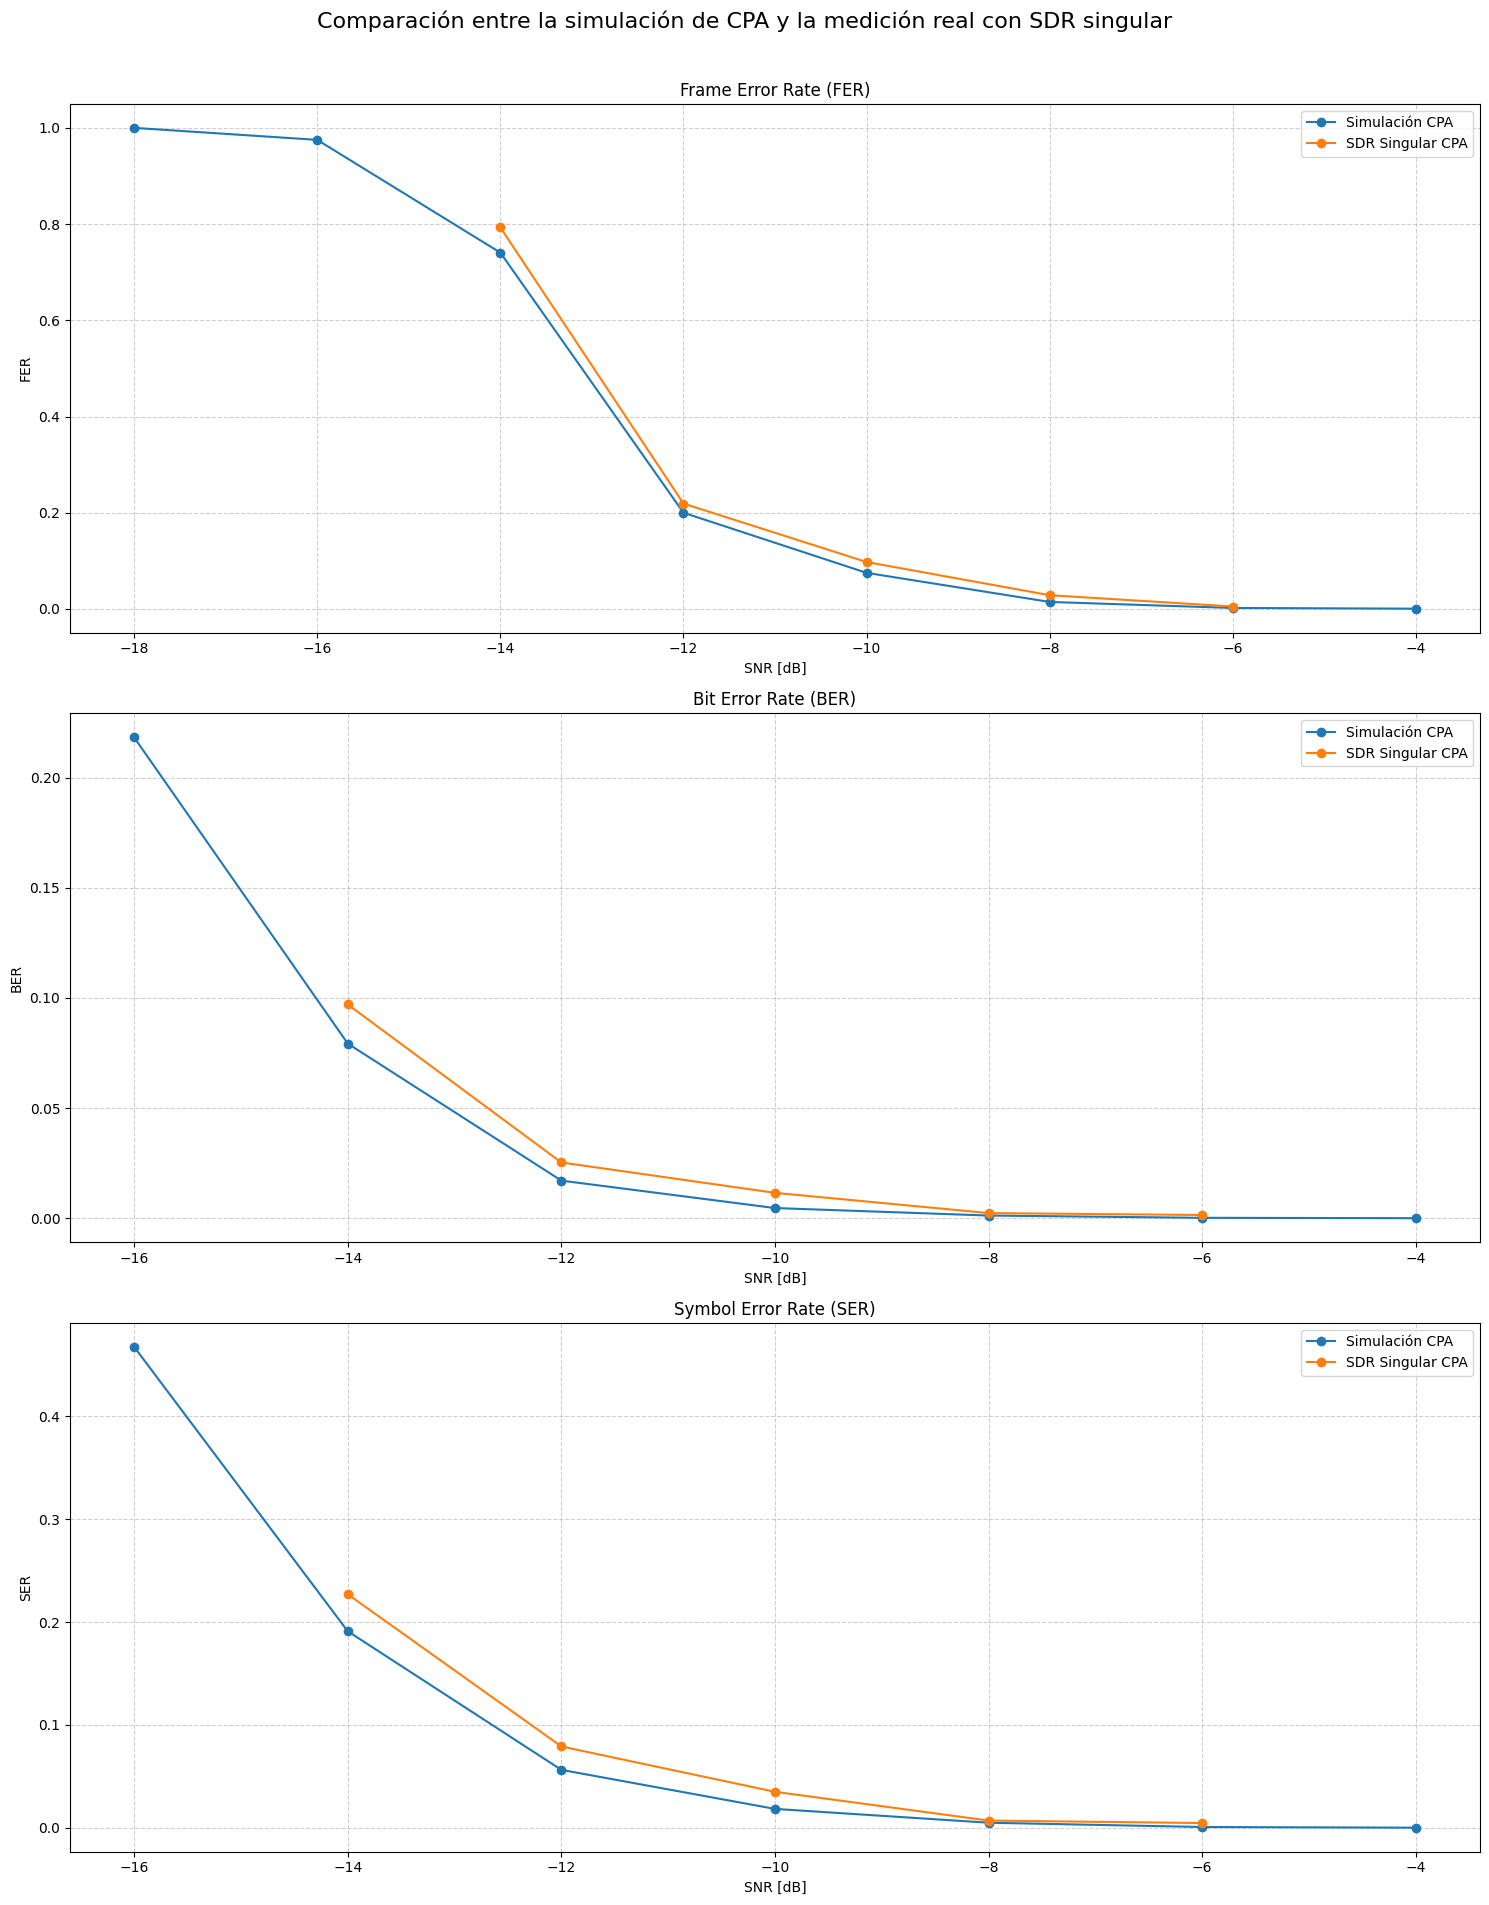

In [8]:
plot_comparison_cpa_sim_sdr()

In [9]:
def plot_comparison_cpa_sim_dual_sdr():    
    sim_cpa_perf = get_perf_metrics("sim_sync_awgn", "8", "cpa")
    sim_snr_db = np.array([pt.snr_db for pt in sim_cpa_perf.snr_points])
    ser = np.array([
        pt.ser.p_hat if pt.ser is not None and pt.ser.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])
        
    sim_fer = np.array([
        pt.fer.p_hat if pt.fer is not None and pt.fer.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])
    sim_ber = np.array([
        pt.ber.p_hat if pt.ber is not None and pt.ber.p_hat is not None else np.nan
        for pt in sim_cpa_perf.snr_points
    ])

    sdr_cpa_perf = get_perf_metrics("real_dual_sdr", "8", "cpa")
    sdr_snr_db = np.array([pt.snr_db for pt in sdr_cpa_perf.snr_points])
    sdr_ser = np.array([pt.ser.p_hat for pt in sdr_cpa_perf.snr_points])
    sdr_fer = np.array([pt.fer.p_hat for pt in sdr_cpa_perf.snr_points])
    sdr_ber = np.array([pt.ber.p_hat for pt in sdr_cpa_perf.snr_points])

    fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    fig.suptitle("Comparación entre la simulación de CPA y la medición real con SDR dual", fontsize=16)

    # 1. Plot Frame Error Rate (FER)
    axs[0].plot(sim_snr_db, sim_fer, label="Simulación CPA", marker='o', linestyle='-')
    axs[0].plot(sdr_snr_db, sdr_fer, label="Dual SDR CPA", marker='o', linestyle='-')
    axs[0].set_xlabel("SNR [dB]")
    axs[0].set_ylabel("FER")
    axs[0].set_title("Frame Error Rate (FER)")
    axs[0].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[0].set_yscale("log")
    axs[0].legend() 

    # 2. Plot Bit Error Rate (BER)
    axs[1].plot(sim_snr_db, sim_ber, label="Simulación CPA", marker='o', linestyle='-')
    axs[1].plot(sdr_snr_db, sdr_ber, label="Dual SDR CPA", marker='o', linestyle='-')
    axs[1].set_xlabel("SNR [dB]")
    axs[1].set_ylabel("BER")
    axs[1].set_title("Bit Error Rate (BER)")
    axs[1].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[1].set_yscale("log")
    axs[1].legend()

    # 3. Plot Symbol Error Rate (SER)
    axs[2].plot(sim_snr_db, ser, label="Simulación CPA", marker='o', linestyle='-')
    axs[2].plot(sdr_snr_db, sdr_ser, label="Dual SDR CPA", marker='o', linestyle='-')
    axs[2].set_xlabel("SNR [dB]")
    axs[2].set_ylabel("SER")
    axs[2].set_title("Symbol Error Rate (SER)")
    axs[2].grid(True, which='both', linestyle='--', alpha=0.6)
    #axs[2].set_yscale("log")
    axs[2].legend() 

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

## Métricas de Rendimiento con SDR Dual

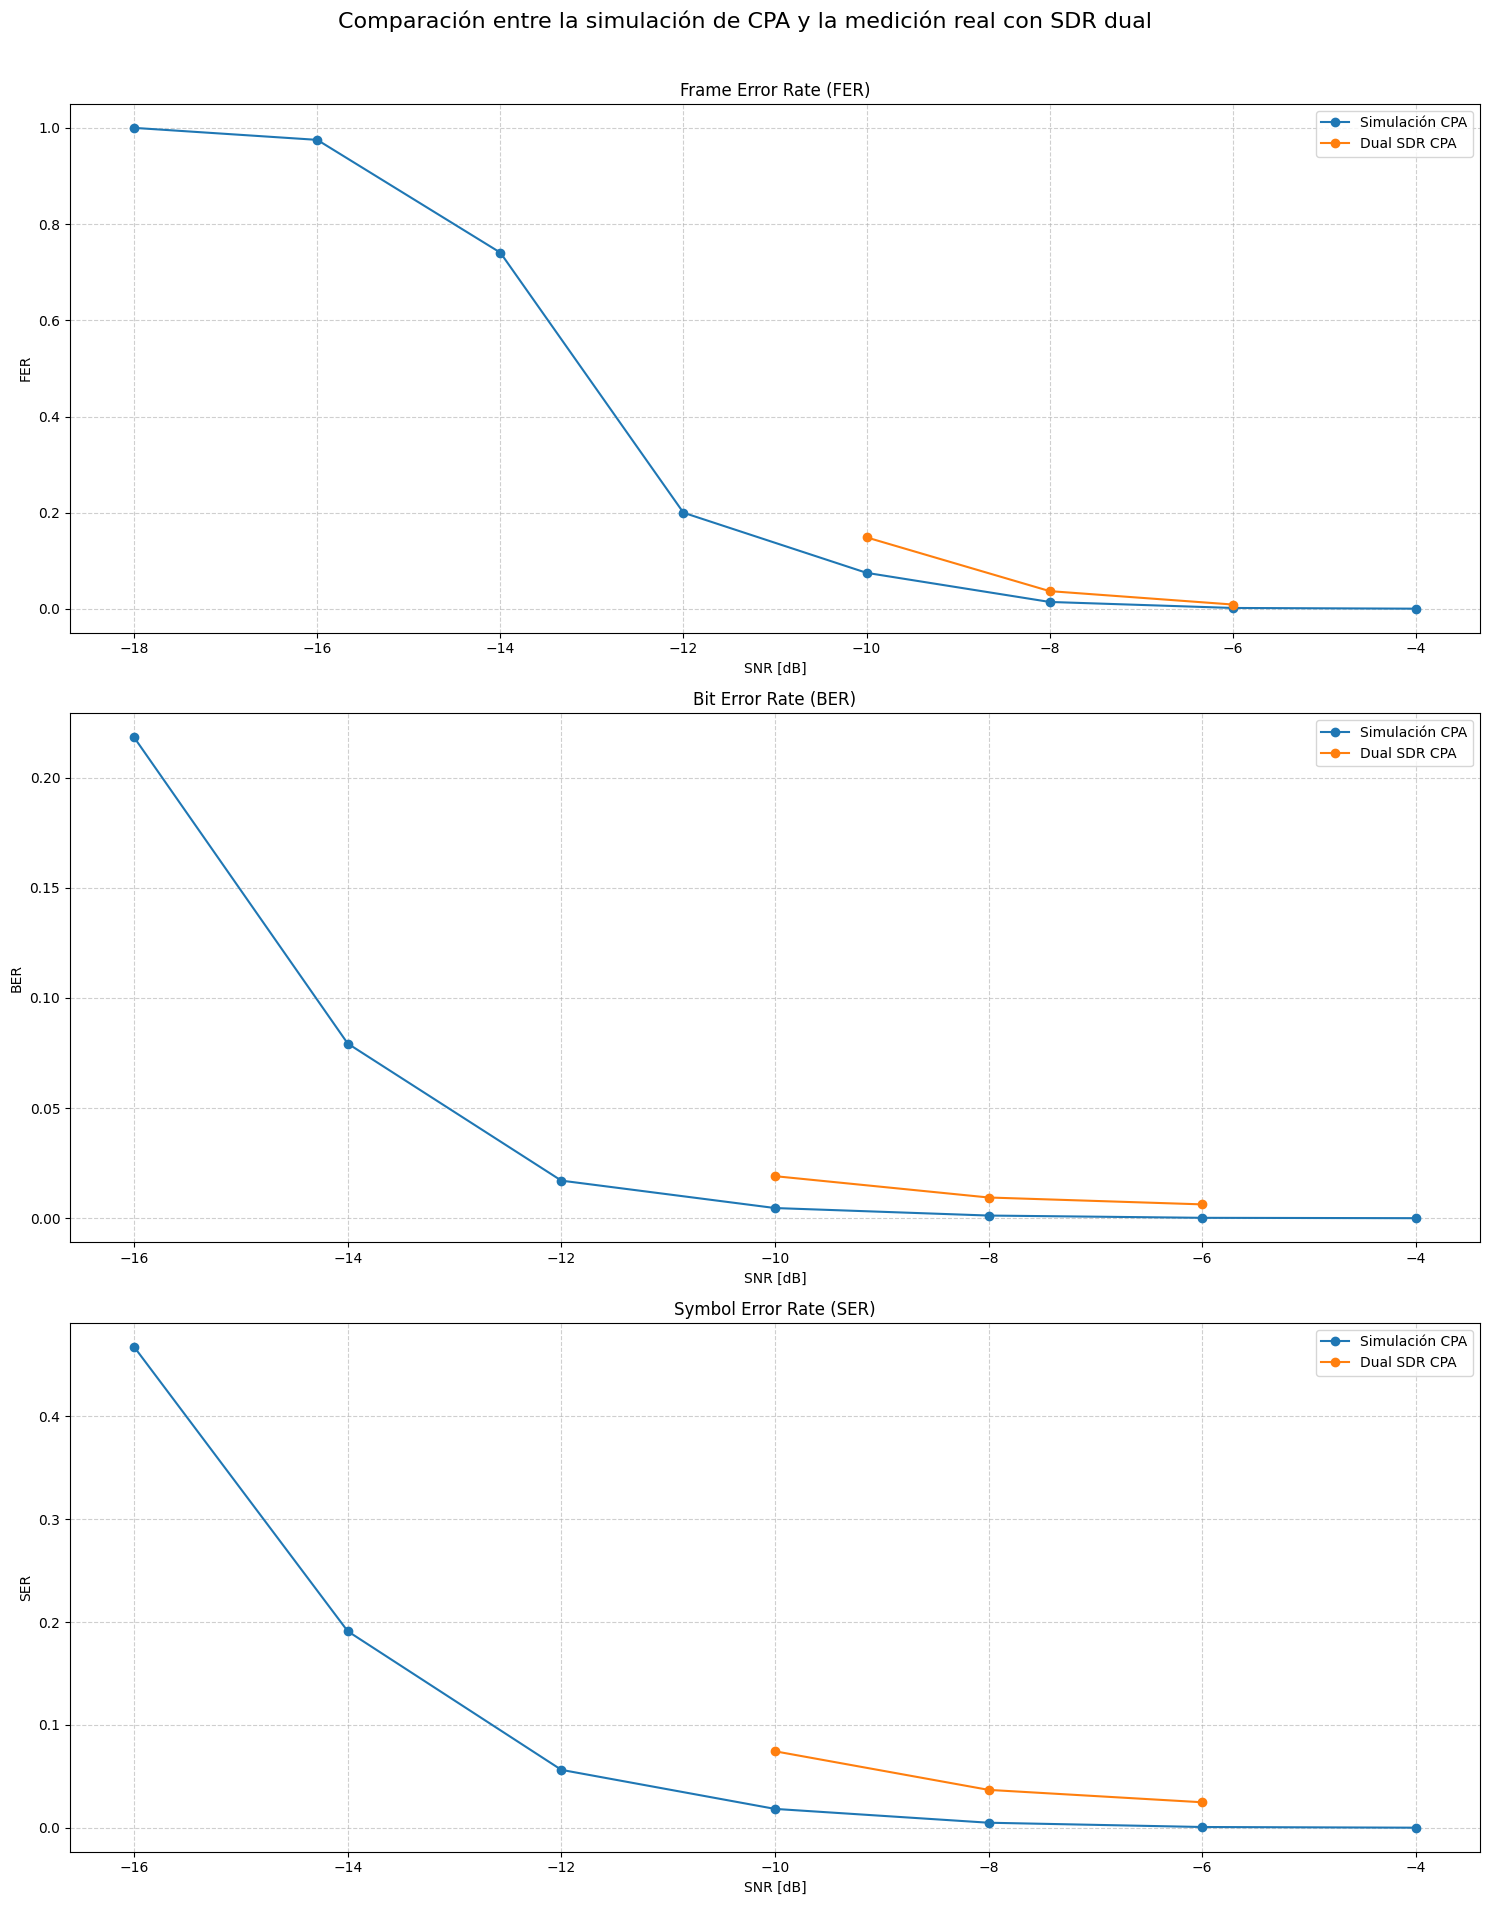

In [10]:
plot_comparison_cpa_sim_dual_sdr()

In [11]:
def plot_comparison_cpa_sim_both_sdr():    
    single_sdr_cpa_perf = get_perf_metrics("real_single_sdr", "8", "cpa")
    single_sdr_snr_db = np.array([pt.snr_db for pt in single_sdr_cpa_perf.snr_points])
    single_sdr_ser = np.array([pt.ser.p_hat for pt in single_sdr_cpa_perf.snr_points])
    single_sdr_fer = np.array([pt.fer.p_hat for pt in single_sdr_cpa_perf.snr_points])
    single_sdr_ber = np.array([pt.ber.p_hat for pt in single_sdr_cpa_perf.snr_points])

    dual_sdr_cpa_perf = get_perf_metrics("real_dual_sdr", "8", "cpa")
    dual_sdr_snr_db = np.array([pt.snr_db for pt in dual_sdr_cpa_perf.snr_points])
    dual_sdr_ser = np.array([pt.ser.p_hat for pt in dual_sdr_cpa_perf.snr_points])
    dual_sdr_fer = np.array([pt.fer.p_hat for pt in dual_sdr_cpa_perf.snr_points])
    dual_sdr_ber = np.array([pt.ber.p_hat for pt in dual_sdr_cpa_perf.snr_points])

    fig, axs = plt.subplots(3, 1, figsize=(15, 20))

    fig.suptitle("Comparación entre la simulación de CPA y la medición real con SDR dual", fontsize=16)

    # 1. Plot Frame Error Rate (FER)
    axs[0].plot(single_sdr_snr_db, single_sdr_fer, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[0].plot(dual_sdr_snr_db, dual_sdr_fer, label="SDR Dual CPA", marker='o', linestyle='-')
    axs[0].set_xlabel("SNR [dB]")
    axs[0].set_ylabel("FER")
    axs[0].set_title("Frame Error Rate (FER)")
    axs[0].grid(True, which='both', linestyle='--', alpha=0.6)
    axs[0].set_yscale("log")
    axs[0].legend() 

    # 2. Plot Bit Error Rate (BER)
    axs[1].plot(single_sdr_snr_db, single_sdr_ber, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[1].plot(dual_sdr_snr_db, dual_sdr_ber, label="SDR Dual CPA", marker='o', linestyle='-')
    axs[1].set_xlabel("SNR [dB]")
    axs[1].set_ylabel("BER")
    axs[1].set_title("Bit Error Rate (BER)")
    axs[1].grid(True, which='both', linestyle='--', alpha=0.6)
    axs[1].set_yscale("log")
    axs[1].legend()

    # 3. Plot Symbol Error Rate (SER)
    axs[2].plot(single_sdr_snr_db, single_sdr_ser, label="SDR Singular CPA", marker='o', linestyle='-')
    axs[2].plot(dual_sdr_snr_db, dual_sdr_ser, label="SDR Dual CPA", marker='o', linestyle='-')
    axs[2].set_xlabel("SNR [dB]")
    axs[2].set_ylabel("SER")
    axs[2].set_title("Symbol Error Rate (SER)")
    axs[2].grid(True, which='both', linestyle='--', alpha=0.6)
    axs[2].set_yscale("log")
    axs[2].legend() 

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

## Métricas de Rendimiento: Comparación SDR Singular vs SDR Dual

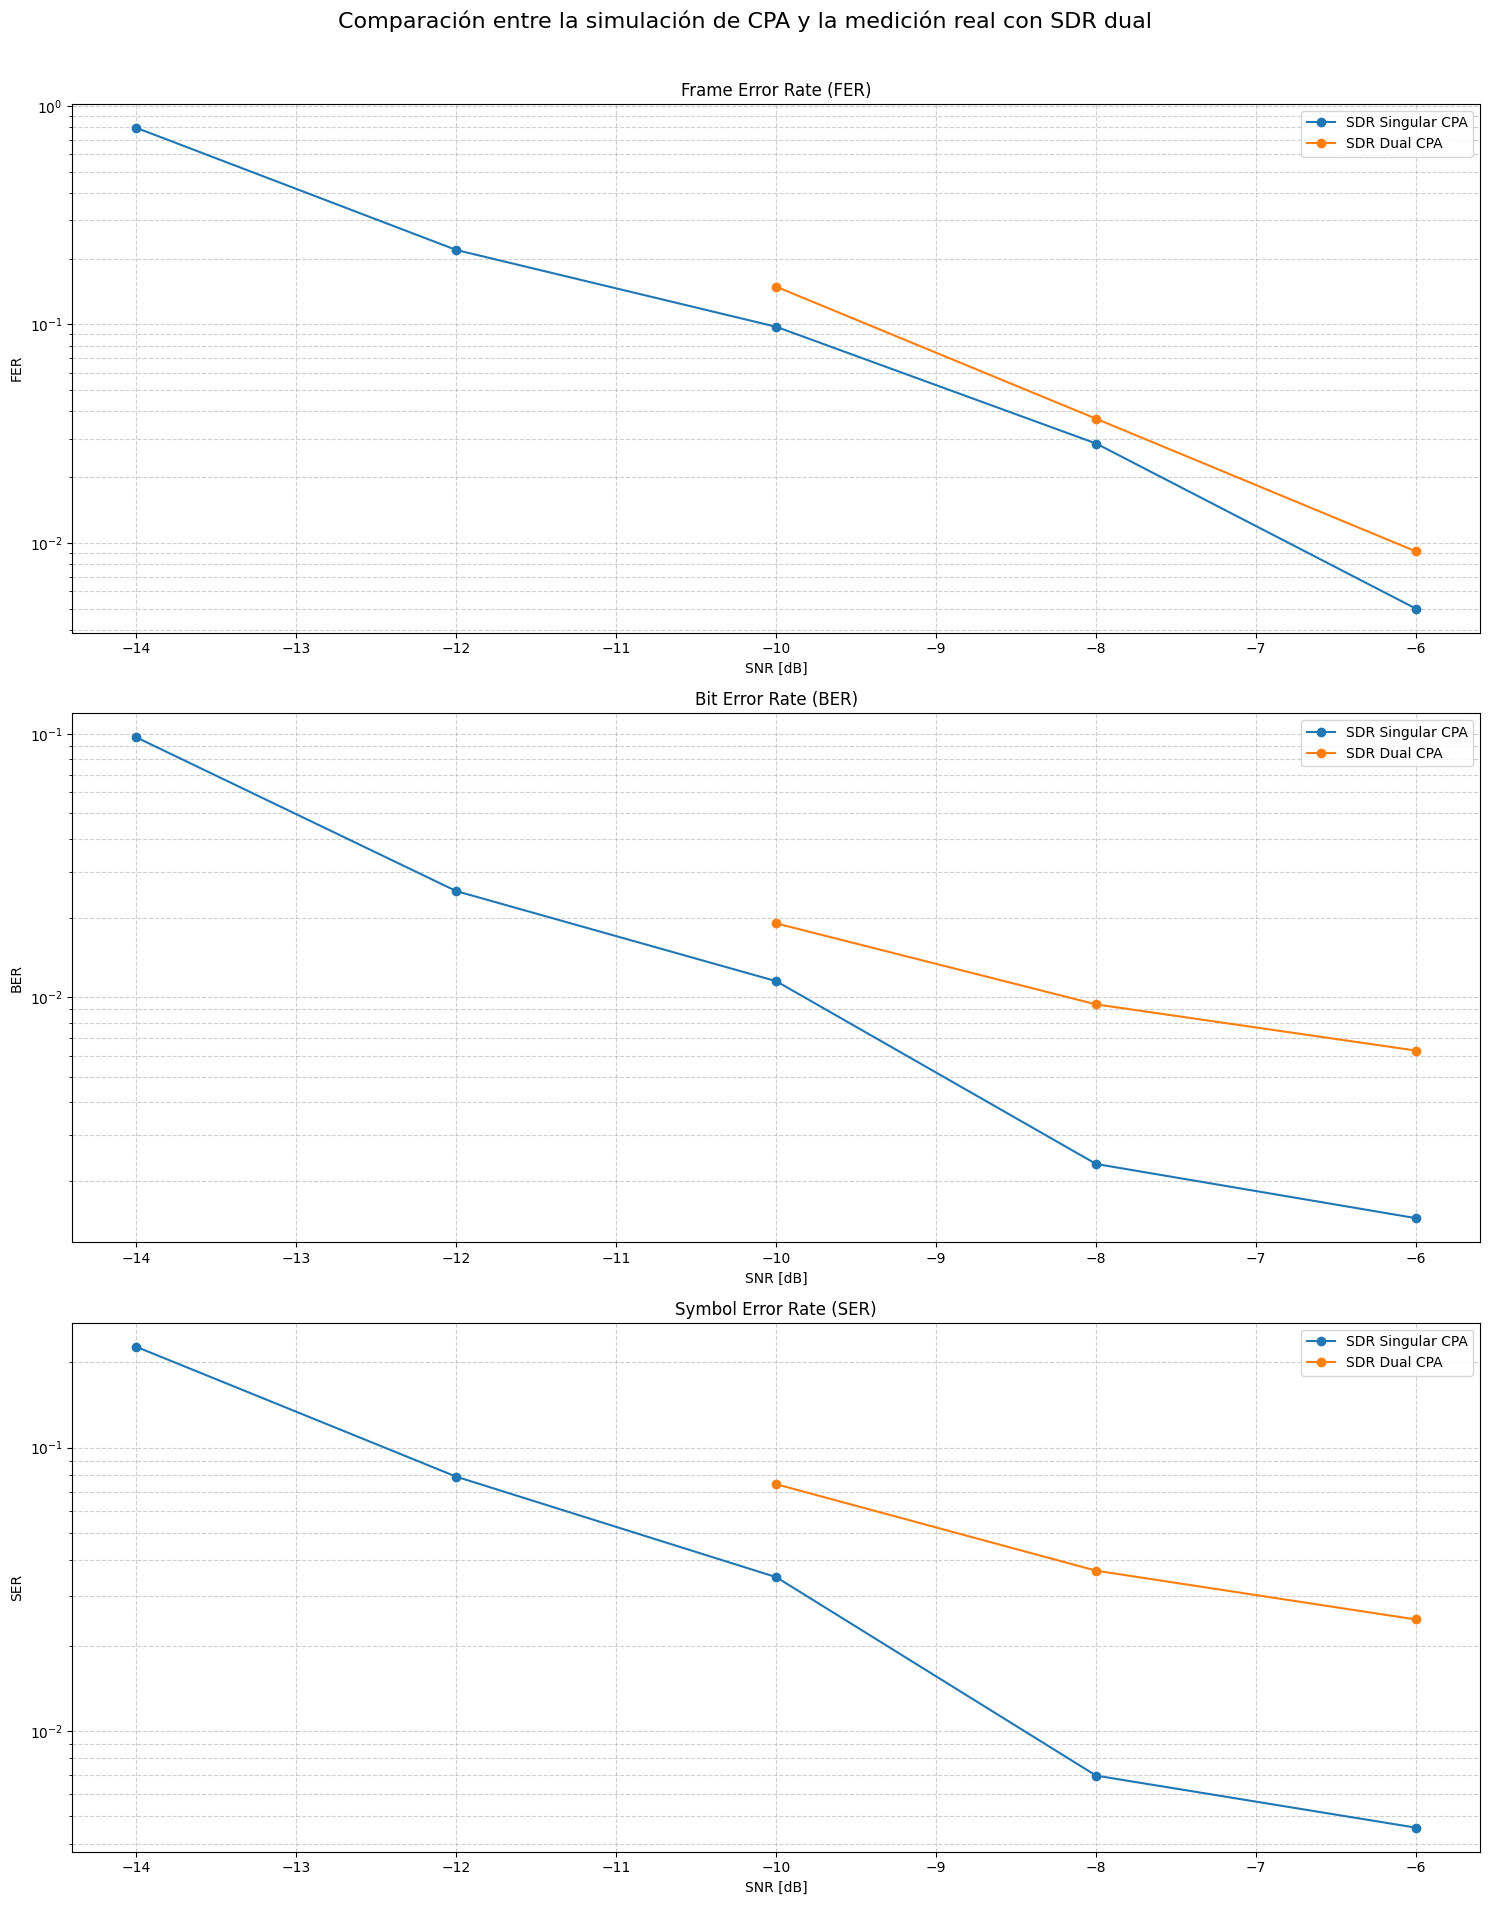

In [12]:
plot_comparison_cpa_sim_both_sdr()